In [4]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sn
import urllib.request
import zipfile

from keras.callbacks import EarlyStopping
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [5]:
num_classes = 7

# Number of dimensions for word embeddings.
embed_num_dims = 300

max_seq_len = 500

In [6]:
data = pd.read_csv('../../data/training_data/data_train_7_classes.csv')

In [ ]:
# Define emotion classes
emotions = ['neutral', 'anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']

In [ ]:
# Data is very skewed, so drop some entries from over populated classes to reduce training time and bias.
data = data.drop(data[data['Emotion'].eq('neutral')].sample(70000).index)
data = data.drop(data[data['Emotion'].eq('happiness')].sample(5000).index)
data.Emotion.value_counts()

neutral      15573
happiness     7885
surprise      1823
sadness       1150
anger         1022
disgust        353
fear           174
Name: Emotion, dtype: int64

In [ ]:
# # Split training data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(data.Text, data.Emotion,
                                                  stratify=data.Emotion, 
                                                  shuffle=True,
                                                  test_size=0.1)
X_test = X_test.tolist()

# # Split training data into training and validation sets.
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train,
                                                  stratify=y_train, 
                                                  shuffle=True,
                                                  test_size=0.2)
X_train = X_train.tolist()
X_dev = X_dev.tolist()

In [ ]:
def clean_text(text):
    """Clean text and tokenise.""" 
    text = text.lower()
    
    # Remove common contractions.
    text = re.sub(r"can't", 'cannot', text)
    text = re.sub(r"\'s",' ', text)
    text = re.sub(r"\'ve", ' have ', text)
    text = re.sub(r"n't", ' not ', text)
    text = re.sub(r" im ", ' i am ', text)
    text = re.sub(r"i'm", 'i am ', text)
    text = re.sub(r"\'re", ' are ', text)
    text = re.sub(r"\'ll", ' will ', text)
    
    # Remove hashtags and tags.
    text = re.sub(r"(#[\d\w\.]+)", '', text)
    text = re.sub(r"(@[\d\w\.]+)", '', text)    
                
    # Remove operations and process punctuation.           
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
  
    # Remove remaining punctuation and missed symbols.
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)

    text = word_tokenize(text)
    return ' '.join(text)

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
texts = [clean_text(text) for text in data.Text]

texts_train = [clean_text(text) for text in X_train]
texts_dev = [clean_text(text) for text in X_dev]
texts_test = [clean_text(text) for text in X_test]

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

seq_train = tokenizer.texts_to_sequences(texts_train)
seq_dev = tokenizer.texts_to_sequences(texts_dev)
seq_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

# Reserve 1 for padding.
vocab_size = len(index_of_words) + 1

In [ ]:
X_train_pad = pad_sequences(seq_train, maxlen = max_seq_len)
X_dev_pad = pad_sequences(seq_dev, maxlen = max_seq_len)
X_test_pad = pad_sequences(seq_test, maxlen = max_seq_len)

In [ ]:
# Assign integer labels to y values.
encoding = {
    'neutral': 0,
    'anger': 1,
    'disgust': 2,
    'fear': 3,
    'happiness': 4,
    'sadness': 5,
    'surprise': 6
}

y_train = [encoding[x] for x in y_train]
y_dev = [encoding[x] for x in y_dev]
y_test = [encoding[x] for x in y_test]

In [ ]:
y_train = to_categorical(y_train)
y_dev = to_categorical(y_dev)
y_test = to_categorical(y_test)

In [ ]:
def create_embedding_matrix(filepath, word_index, embedding_dim, vocab_size):
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [ ]:
fname = 'embeddings/wiki-news-300d-1M.vec'
if not os.path.isfile(fname):
    print('Geting word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('Done.')
    os.remove('wiki-news-300d-1M.vec.zip')

Geting word vectors...
Done.


In [ ]:
embedding_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims, vocab_size)

In [ ]:
# The following hyperparameters have been tried before settling on the best ones.
# A model has been created for each set and performances compared, code is omitted for clarity.
kernel_sizes = [3, 5]
filters = [64, 128, 256]
learning_rates = [0.01, 0.001, 0.0001]
max_seq_length = [300, 500]

In [46]:
# Define final model.
kernel_size = 3
filters = 256

embedding_layer = Embedding(vocab_size,
                            embed_num_dims,
                            input_length = max_seq_len,
                            weights = [embedding_matrix],
                            trainable=False)

model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 300)          3417000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 498, 256)          230656    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 1799      
Total params: 3,715,247
Trainable params: 298,247
Non-trainable params: 3,417,000
_________________________________________________________________


In [47]:
batch_size = 64
max_epochs = 50
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

history = model.fit(X_train_pad, y_train, 
                    batch_size=batch_size,
                    epochs=max_epochs,
                    validation_data=(X_dev_pad, y_dev),
                    callbacks=[early_stopping_monitor])

Epoch 1/50
315/315 [==============================] - 8s 23ms/step - loss: 1.3343 - accuracy: 0.5522 - val_loss: 1.0398 - val_accuracy: 0.6540
Epoch 2/50
315/315 [==============================] - 7s 22ms/step - loss: 0.9977 - accuracy: 0.6634 - val_loss: 0.9187 - val_accuracy: 0.6825
Epoch 3/50
315/315 [==============================] - 7s 22ms/step - loss: 0.8719 - accuracy: 0.6900 - val_loss: 0.8435 - val_accuracy: 0.7062
Epoch 4/50
315/315 [==============================] - 7s 22ms/step - loss: 0.7919 - accuracy: 0.7163 - val_loss: 0.8120 - val_accuracy: 0.7115
Epoch 5/50
315/315 [==============================] - 7s 22ms/step - loss: 0.7450 - accuracy: 0.7298 - val_loss: 0.8020 - val_accuracy: 0.7139
Epoch 6/50
315/315 [==============================] - 7s 22ms/step - loss: 0.7151 - accuracy: 0.7410 - val_loss: 0.7832 - val_accuracy: 0.7187
Epoch 7/50
315/315 [==============================] - 7s 22ms/step - loss: 0.6741 - accuracy: 0.7578 - val_loss: 0.7787 - val_accuracy: 0.7197

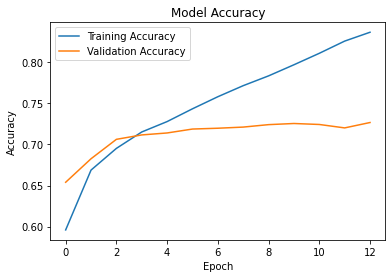

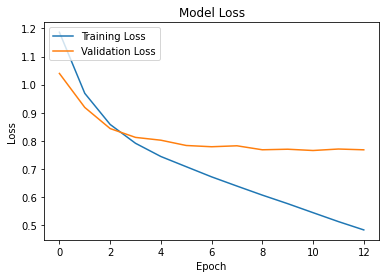

In [48]:
# Plot loss and accuracy.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.show()

In [49]:
# See test set results.
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [emotions[pred] for pred in predictions]

In [50]:
y_test_emo = [emotions[np.where(i == 1)[0][0]] for i in y_test]

In [52]:
print('CNN 7 classes classification report: ') 
print(classification_report(y_test_emo, predictions, digits=4))

CNN 7 classes classification report: 
              precision    recall  f1-score   support

       anger     0.4490    0.2157    0.2914       102
     disgust     0.0000    0.0000    0.0000        35
        fear     0.0000    0.0000    0.0000        18
   happiness     0.7064    0.6679    0.6866       789
     neutral     0.7350    0.8446    0.7860      1557
     sadness     0.4948    0.4174    0.4528       115
    surprise     0.7607    0.4890    0.5953       182

    accuracy                         0.7152      2798
   macro avg     0.4494    0.3764    0.4017      2798
weighted avg     0.6944    0.7152    0.6990      2798



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'CNN 7 classes confusion matrix')

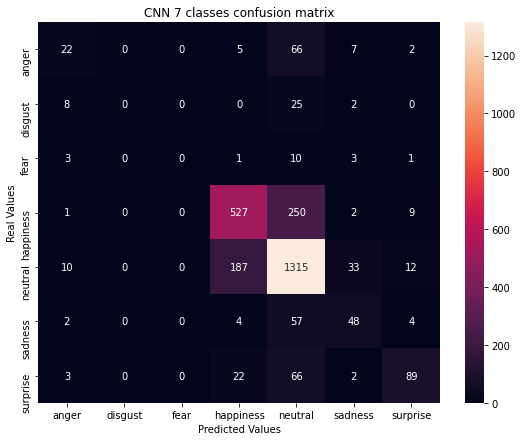

In [53]:
# Get confusion matrix.
df_cm = pd.DataFrame(confusion_matrix(y_test_emo, predictions), index = [i for i in ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']],
                  columns = [i for i in ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']])
plt.figure(figsize = (9,7))
hm = sn.heatmap(df_cm, annot=True, fmt='g')
hm.set_xlabel('Predicted Values')
hm.set_ylabel('Real Values')
hm.set_title('CNN 7 classes confusion matrix')